# Drawing predicted circuits

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import fancy_einsum
from tqdm import tqdm
import re
from sklearn.metrics import roc_curve, auc
import transformer_lens.utils as utils
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from sparse_autoencoder import SparseAutoencoder
from common_utils import *

/Users/charlesoneill/miniconda3/envs/anu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Run each of the three datasets with and without softmax across layer 
datasets = ['gt', 'ds', 'ioi']
dataset_results = {}

task_mappings = {
    'ioi': 'Indirect Object Identification',
    'gt': 'Greater-than',
    'ds': 'Docstring'
}

dataset = 'ioi'
print(f"Dataset: {dataset}")
# Load residual streams
device = 'cpu'
task = dataset
resid_streams = torch.load(f"../data/{task}/resid_heads_mean.pt").to(device)
print(f"Residual streams shape: {resid_streams.shape}")
head_labels = torch.load(f'../data/{task}/labels_heads_mean.pt')
ground_truth = torch.load(f'../data/{task}/ground_truth.pt')

print(f"Ground truth: {ground_truth}")

# Load save_dict
savepath = f"../models/{task}/sparse_autoencoder_dict.pt"
save_dict = torch.load(savepath)
num_unique = save_dict['node_best_num_unique']
print(f"Number of unique features: {num_unique}")
lambda_ = save_dict['node_best_lambda']
print(f"Lambda: {lambda_}")
best_roc_auc = save_dict['node_best_roc_auc']
print(f"Best ROC AUC: {best_roc_auc}")

model = SparseAutoencoder(n_input_features=resid_streams.shape[-1], n_learned_features=num_unique, geometric_median_dataset=None).to(device)

# Load the model
model.load_state_dict(save_dict['model'])

# Plot the ground truth (head, layer) pairs (1 if in ground truth, 0 otherwise)
heads = []
layers = []
for i, l in enumerate(head_labels):
    layer, head = feature_string_to_head_and_layer(i, head_labels)
    heads.append(head)
    layers.append(layer)

heads = list(set(heads))
layers = list(set(layers))

ground_truth_array = np.zeros((len(layers), len(heads)))
for layer, head in ground_truth:
    ground_truth_array[layer, head] = 1

model.eval()
learned_activations = model(resid_streams)[0].detach().cpu().numpy()
all_indices = np.argmax(learned_activations, axis=2)

normalise = False

# Normalise across layer
print(f"Normalise across layer")
y_true, y_pred, fpr, tpr, node_roc_auc, f1, thresholds, original = gen_softmaxed_unique_to_pos(all_indices, ground_truth_array, head_labels, normalise=normalise, across_layer=False, return_original=True)

# Print best f1 score (and corresponding threshold)
node_best_f1 = np.max(f1)
best_index = np.argmax(f1)
best_threshold = thresholds[best_index]
print(f"Best F1 score: {node_best_f1:.4f}")
print(f"ROC AUC: {node_roc_auc:.4f}")

Dataset: ioi
Residual streams shape: torch.Size([500, 144, 768])
Ground truth: [(2, 2), (4, 11), (0, 1), (3, 0), (0, 10), (5, 5), (6, 9), (5, 8), (5, 9), (7, 3), (7, 9), (8, 6), (8, 10), (10, 7), (11, 10), (9, 9), (9, 6), (10, 0), (10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (11, 9), (11, 3), (9, 7)]
Number of unique features: 187
Lambda: 0.02393969388660661
Best ROC AUC: 0.8893415906127771
Normalise across layer
Best F1 score: 0.7934
ROC AUC: 0.8893


In [19]:
best_index = np.argmax(f1)
circuit_prediction = (y_pred > thresholds[best_index]).astype(int)
# Reshape circuit prediction to n_layers x n_heads
circuit_prediction = circuit_prediction.reshape((len(layers), len(heads)))

In [20]:
# Create list of (layer, head) pairs in the circuit
circuit = []
for i, l in enumerate(circuit_prediction):
    for j, h in enumerate(l):
        if h == 1:
            circuit.append((i, j))

circuit

[(0, 1),
 (0, 3),
 (0, 10),
 (1, 5),
 (2, 2),
 (2, 6),
 (2, 10),
 (3, 4),
 (3, 6),
 (4, 3),
 (5, 2),
 (5, 10),
 (6, 0),
 (6, 7),
 (6, 9),
 (7, 9),
 (8, 2),
 (8, 4),
 (8, 5),
 (8, 6),
 (8, 10),
 (8, 11),
 (9, 0),
 (9, 2),
 (9, 5),
 (9, 6),
 (9, 7),
 (9, 8),
 (9, 9),
 (10, 0),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 6),
 (10, 7),
 (10, 10),
 (11, 2),
 (11, 3),
 (11, 6),
 (11, 10)]

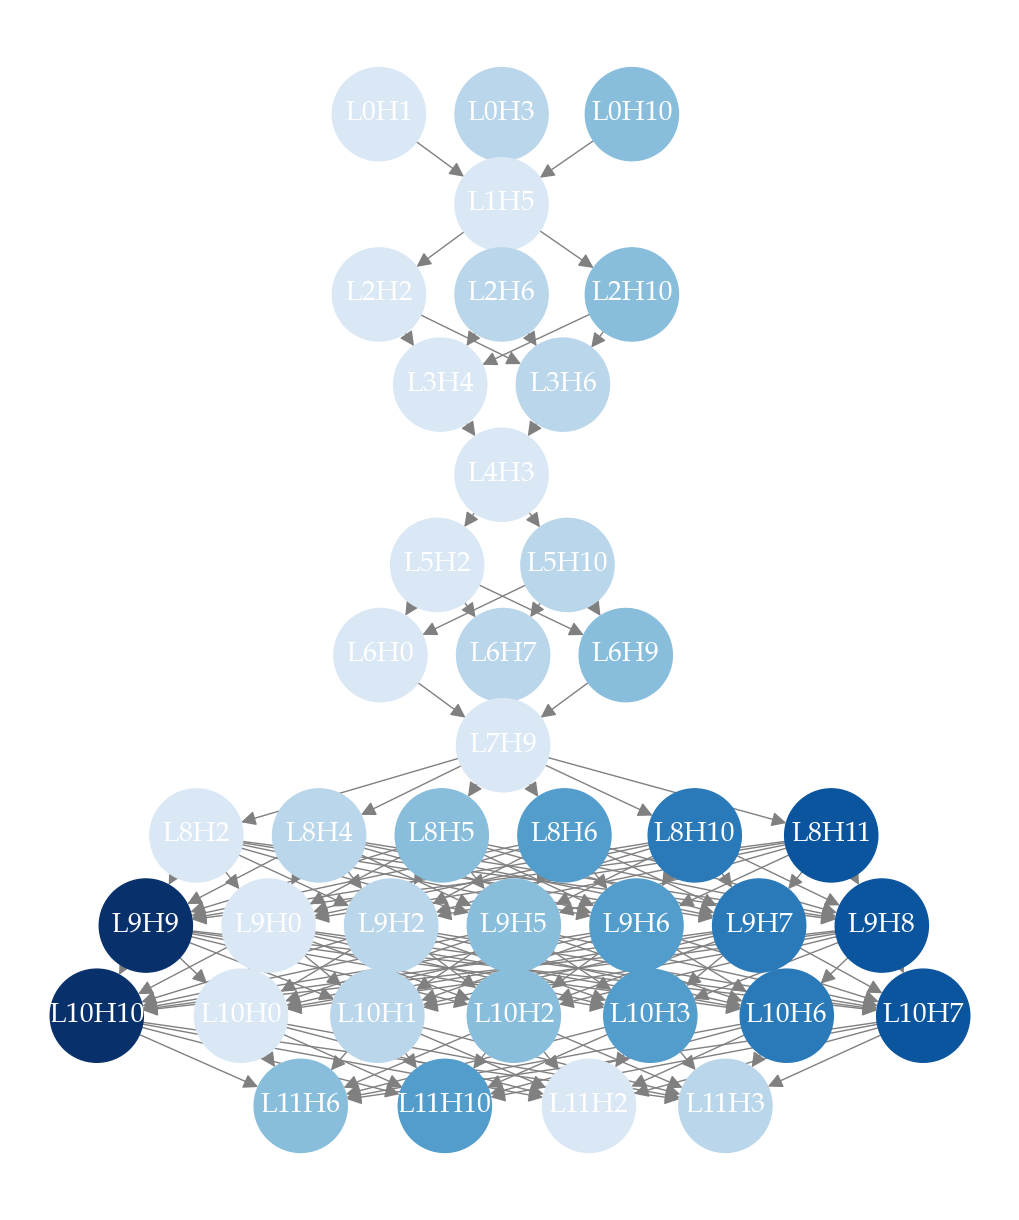

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.colors as mcolors
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the default font to Palatino

# Set a sophisticated and publication-quality style
mpl.rcParams.update({
    'font.size': 18,
    'font.family': 'Palatino',
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

def rgba_to_hex(rgba):
    # Convert an RGBA color to a hex string
    return '#{:02x}{:02x}{:02x}'.format(int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))

def draw_transformer_circuit_with_graphviz(circuit):
    G = nx.DiGraph()

    # Prepare to track layers and their heads
    layer_dict = {}
    for layer, head in circuit:
        if layer not in layer_dict:
            layer_dict[layer] = []
        layer_dict[layer].append(head)
    
    # Sort heads within each layer
    for layer in layer_dict:
        layer_dict[layer].sort()

    # Find the maximum number of heads in any layer for normalization
    max_heads = max(len(heads) for heads in layer_dict.values())

    # Create a colormap from grey to blue
    cmap = plt.cm.Blues  # Choose a blue colormap
    norm = mcolors.Normalize(vmin=0, vmax=max_heads)  # Normalize from 0 to max_heads

    # Add nodes in sorted order to ensure left-to-right positioning
    for layer in sorted(layer_dict.keys()):
        for head in layer_dict[layer]:
            normalized_value = (layer_dict[layer].index(head) + 1) / len(layer_dict[layer])
            color = cmap(norm(len(layer_dict[layer]) * normalized_value))
            hex_color = rgba_to_hex(color)  # Convert RGBA to hex
            G.add_node((layer, head), label=f"L{layer}H{head}", style='filled', fillcolor=hex_color)

    # Sort layers to facilitate connection logic
    sorted_layers = sorted(layer_dict.keys())

    # Add edges considering closest available subsequent layer
    for i, layer in enumerate(sorted_layers):
        for head in layer_dict[layer]:
            # Find the closest subsequent layer
            for next_layer in sorted_layers[i+1:]:
                if next_layer > layer:
                    for next_head in layer_dict[next_layer]:
                        G.add_edge((layer, head), (next_layer, next_head))
                    break

    # Use pygraphviz to position nodes by layers
    A = nx.nx_agraph.to_agraph(G)
    A.layout(prog='dot')  # Use the 'dot' engine for a top-down layout

    #print([f"L{n[0]}H{n[1]}" for n in G.nodes()])

    # Set a sophisticated and publication-quality style

    # Draw the graph
    plt.figure(figsize=(10, 12))  # Adjusted for potentially wider graphs
    pos = graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, labels={n: f"L{n[0]}H{n[1]}" for n in G.nodes()},
            node_color=[G.nodes[n]['fillcolor'] for n in G.nodes()],
            node_size=4500, font_size=20, font_family='Palatino', font_color='white',
            arrowstyle='-|>', arrowsize=22, edge_color='gray')
    
    # Make the font Palatino
    plt.rcParams['font.family'] = 'Palatino'
    #plt.title(f"{task_mappings[dataset]}")
    # Save figure
    plt.savefig(f"../output/figures/{dataset}_final_circuit.pdf", bbox_inches='tight')
    plt.show()

# Example usage with the provided circuit
draw_transformer_circuit_with_graphviz(circuit)

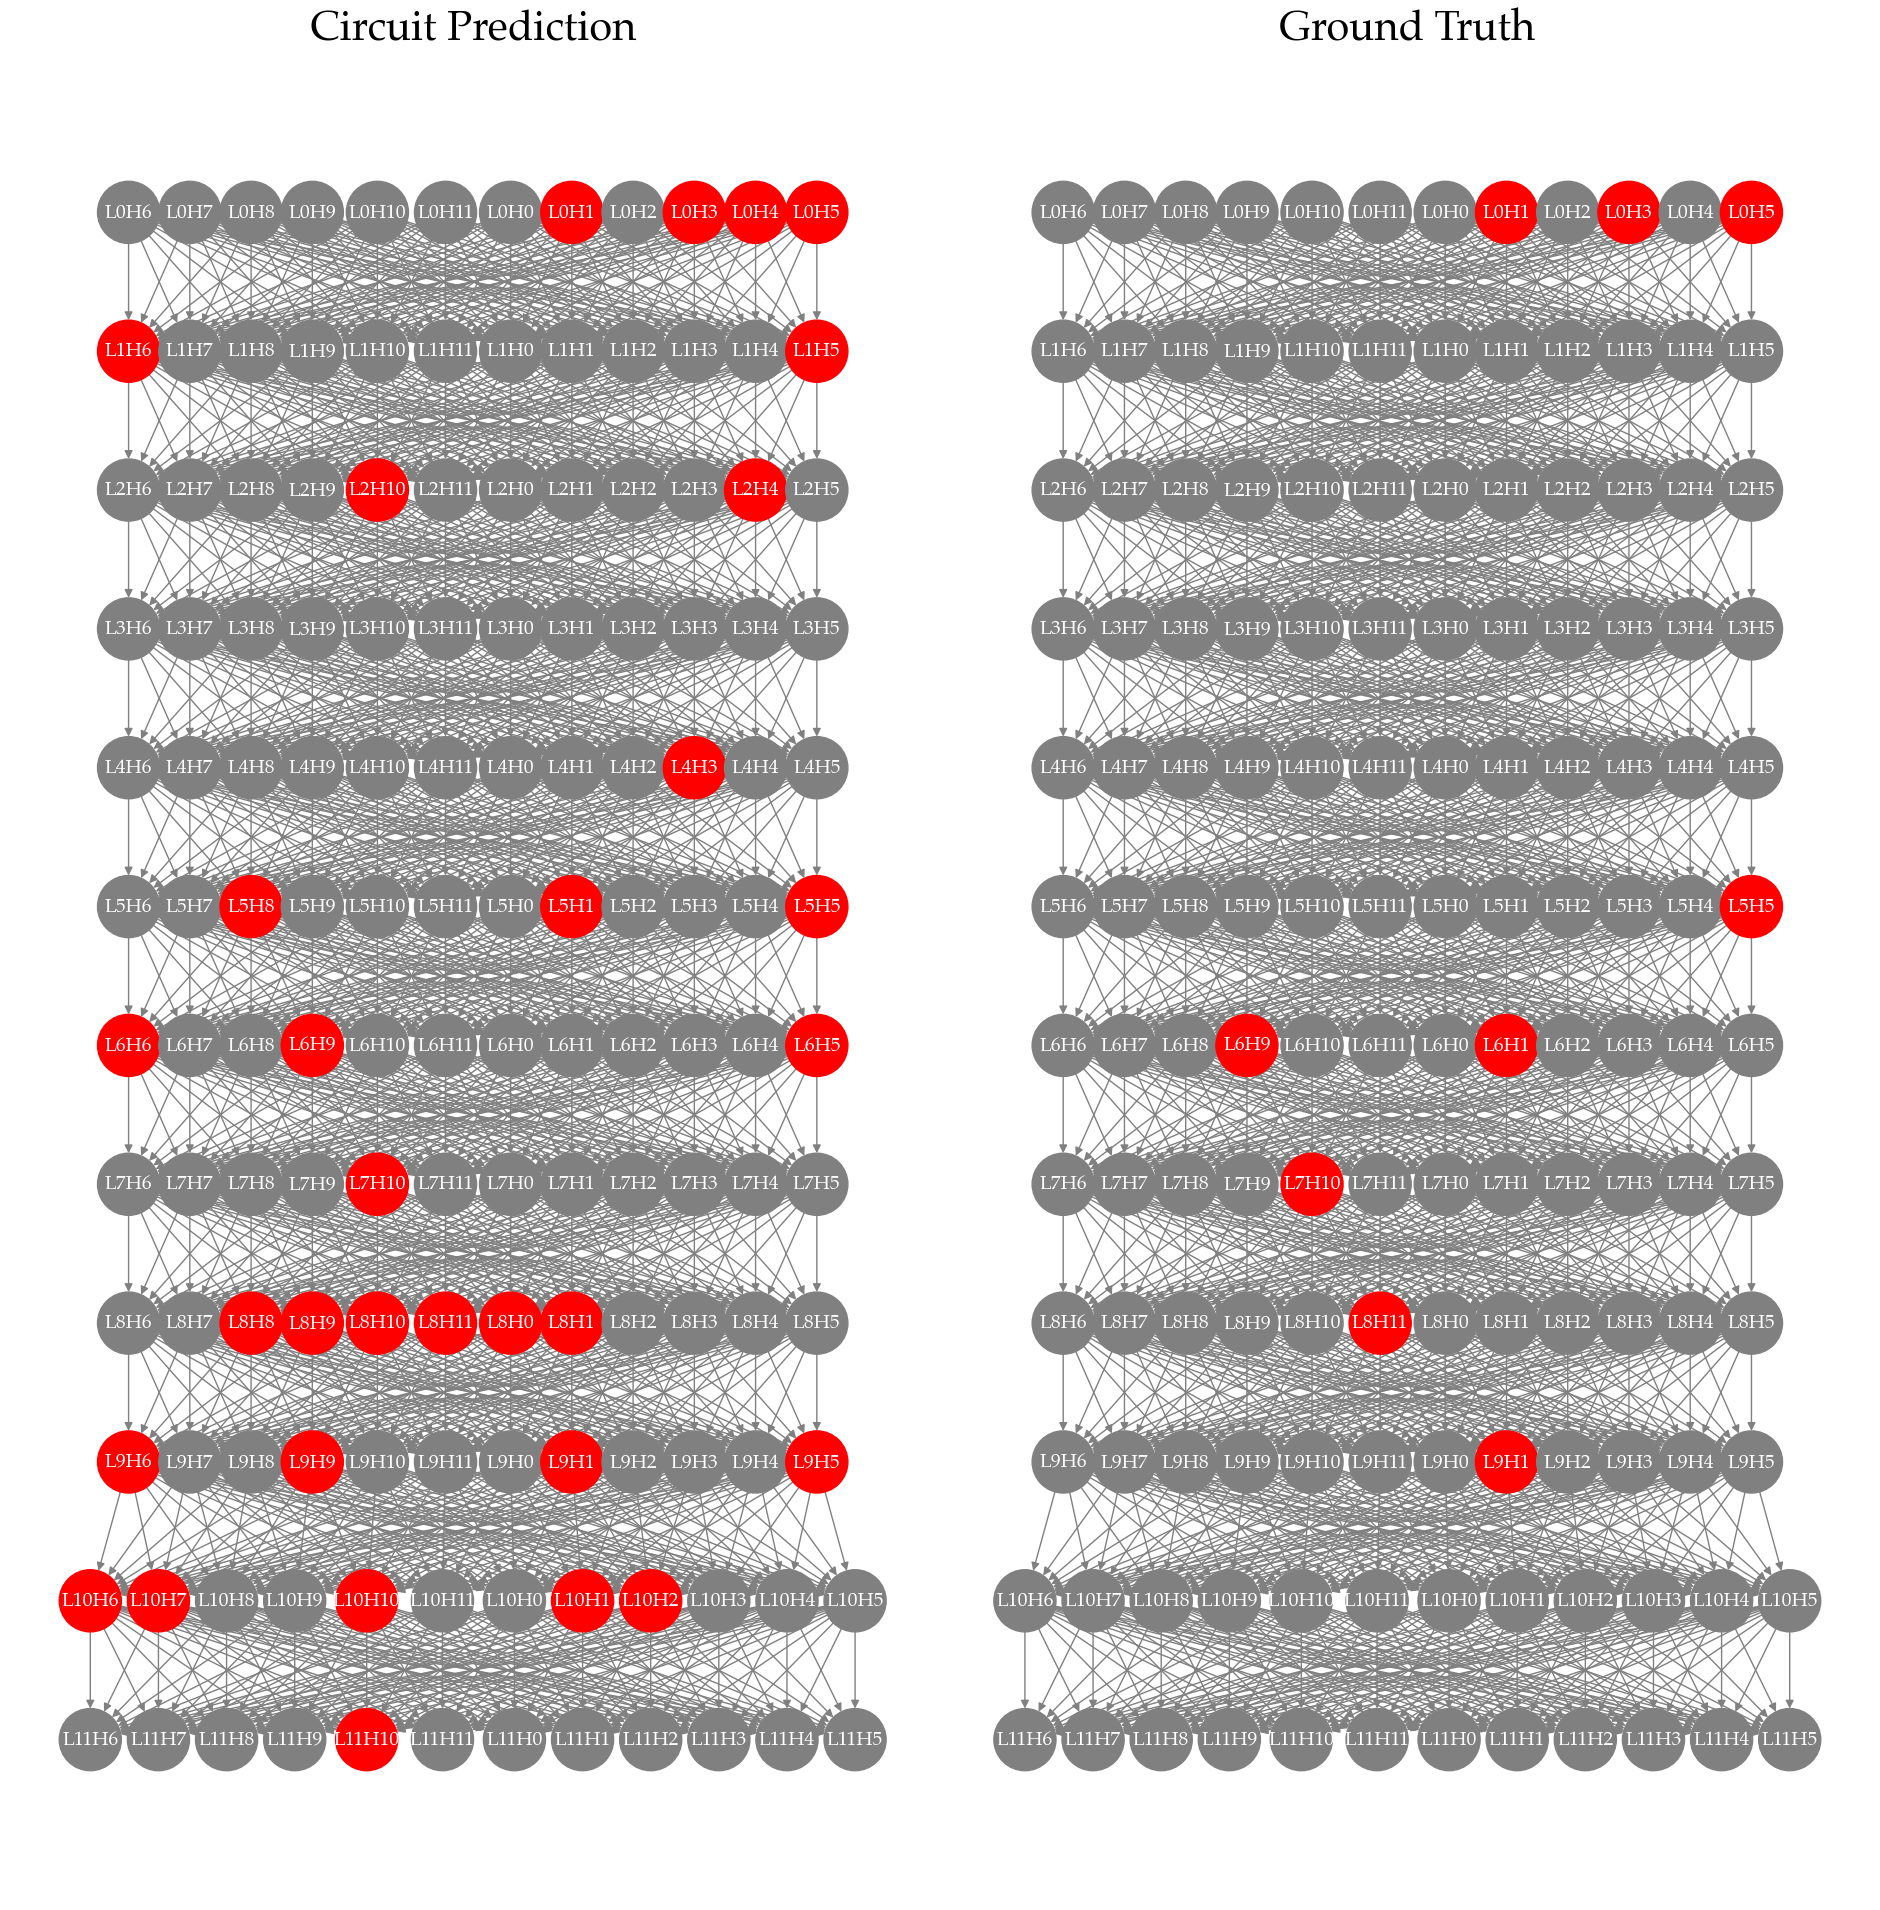

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.colors as mcolors

def draw_transformer_circuits_side_by_side(layers, heads, circuit, ground_truth):
    fig, axes = plt.subplots(1, 2, figsize=(24, 24))  # Set up a figure with two subplots

    plt.subplots_adjust(wspace=0.01)  # Adjust horizontal space between subplots
    
    # Function to draw a single transformer circuit graph
    def draw_transformer_circuit(ax, layers, heads, circuit_data, title):
        G = nx.DiGraph()

        # Add all possible nodes from given layers and heads
        all_nodes = {(layer, head): 'gray' for layer in layers for head in heads}

        # Mark nodes from the circuit in red
        for layer, head in circuit_data:
            all_nodes[(layer, head)] = 'red'

        # Add nodes to the graph
        for (layer, head), color in all_nodes.items():
            G.add_node((layer, head), label=f"L{layer}H{head}", style='filled', fillcolor=color)

        # Create edges based on the next available layer logic
        sorted_layers = sorted(set(layers))
        for layer in sorted_layers:
            current_heads = [head for (l, head), color in all_nodes.items() if l == layer]
            for head in current_heads:
                # Find the closest subsequent layer that contains nodes
                next_layer = None
                for potential_next_layer in sorted_layers:
                    if potential_next_layer > layer:
                        next_heads = [h for (l, h), color in all_nodes.items() if l == potential_next_layer]
                        if next_heads:
                            next_layer = potential_next_layer
                            break
                if next_layer:
                    next_heads = [h for (l, h), color in all_nodes.items() if l == next_layer]
                    for next_head in next_heads:
                        G.add_edge((layer, head), (next_layer, next_head))

        # Use pygraphviz to position nodes by layers
        A = nx.nx_agraph.to_agraph(G)
        A.layout(prog='dot')  # Use the 'dot' engine for a top-down layout

        # Draw the graph using matplotlib
        pos = graphviz_layout(G, prog='dot')
        node_colors = [G.nodes[n]['fillcolor'] for n in G.nodes()]
        nx.draw(G, pos, with_labels=True, labels={n: f"L{n[0]}H{n[1]}" for n in G.nodes()},
                node_color=node_colors, node_size=2000, font_size=14, font_family='Palatino', font_color='white',
                arrowstyle='-|>', arrowsize=12, edge_color='gray', ax=ax)
        ax.set_title(title, pad=-100, fontsize=30)  # Reduce the padding to bring the title closer

    # Draw the first circuit
    draw_transformer_circuit(axes[0], layers, heads, circuit, "Circuit Prediction")

    # Draw the ground truth circuit
    draw_transformer_circuit(axes[1], layers, heads, ground_truth, "Ground Truth")

    # Save figure
    plt.savefig(f"../output/figures/{dataset}_final_circuit_comparison.png")

    plt.show()


# Example usage with the provided circuit and ground truth
draw_transformer_circuits_side_by_side(layers, heads, circuit, ground_truth)